# Programming Assignment 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set all the parameters to be used later

# Network structure
sizes = [785, 64, 10]

# Meta parameters
eta0 = 1e1  # initial learning rate
tau = 100  # annealing time scale
mu = 0.9  # momentum parameter
minibatch_size = 1024
capture_interval = 10

# Stopping criteria
epoch_min, epoch_max, early_stopping = 1, 10, 3

In [3]:
# Define some convenience functions
import os
from toynn.train import train


# Train a network without tricks
from toynn.network import NaiveNetwork
def naive_train(sizes):
    return train(
        NaiveNetwork(sizes), dss,
        eta0=eta0, tau=tau,
        epoch_min=epoch_min, epoch_max=epoch_max,
        early_stopping=early_stopping
    )


# Train a network with tricks
from toynn.network import TrickNetwork
def trick_train(sizes):
    return train(
        TrickNetwork(sizes), dss,
        eta0=eta0, tau=tau, mu=mu,
        minibatch_size=minibatch_size,
        capture_interval=capture_interval,
        epoch_min=epoch_min, epoch_max=epoch_max,
        early_stopping=early_stopping
    )


# Report training result
def report(result, title):
    # Make sure the `figs` directory exists
    os.makedirs('figs', exist_ok=True)
    for quantity in ['accuracy']:
        result.plot_history(quantity)
        plt.title(title.capitalize())
        plt.savefig('figs/{}_{}.pdf'.format(title, quantity))

In [4]:
# Read the MNIST data sets
from toynn.data import read_data_sets
dss = read_data_sets()
print('Training set size:', dss.training.size)
print('Validation set size:', dss.validation.size)
print('Test set size:', dss.test.size)

Training set size: 50000
Validation set size: 10000
Test set size: 10000


## Classification

### Checking Gradients

In [5]:
net = NaiveNetwork(sizes)
net.initialize()
net.feed_data(dss.training.images[:10, :], dss.training.labels[:10, :])
net.fprop()
net.bprop()

def deltaE(l, i, j, eps=1e-2):
    w = net.layers[l].w[i, j]
    net.layers[l].w[i, j] = w + eps
    net.fprop()
    Ep = net.loss
    net.layers[l].w[i, j] = w - eps
    net.fprop()
    Em = net.loss
    net.layers[l].w[i, j] = w
    return (Ep - Em) / (2 * eps)

for l in [1, 2]:
    layer = net.layers[l]
    i = np.random.randint(layer.w.shape[0])
    j = np.random.randint(layer.w.shape[1])
    print(layer.grad[i, j], deltaE(l, i, j))

-1.56439498002e-05 -1.56439518229e-05
-0.0507254489762 -0.0507253003117


### Gradient Descent

In [6]:
%%time
result_naive = naive_train(sizes)

CPU times: user 21 s, sys: 5 s, total: 26 s
Wall time: 15.4 s


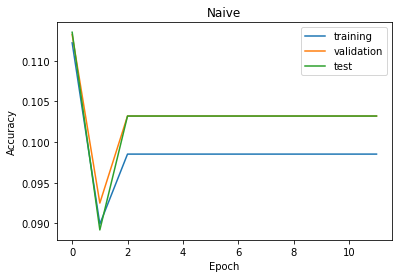

In [7]:
report(result_naive, 'naive')

## Tricks of the Trade

In [8]:
%%time
result_trick = trick_train(sizes)

CPU times: user 54 s, sys: 8.72 s, total: 1min 2s
Wall time: 36.3 s


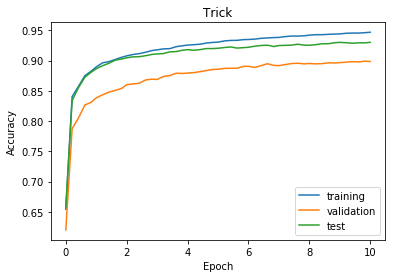

In [9]:
report(result_trick, 'trick')

## Network Topology

### Number of Hidden Units

In [10]:
%%time
sizes_narrow = sizes.copy()
sizes_narrow[1] //= 2
result_narrow = trick_train(sizes_narrow)

CPU times: user 37.2 s, sys: 7.63 s, total: 44.8 s
Wall time: 27.5 s


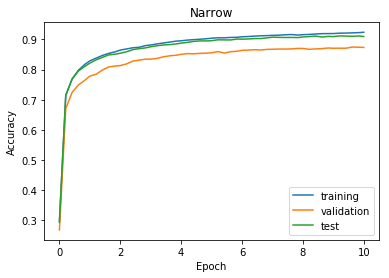

In [11]:
report(result_narrow, 'narrow')

In [12]:
%%time
sizes_wide = sizes.copy()
sizes_wide[1] *= 2
result_wide = trick_train(sizes_wide)

CPU times: user 1min 39s, sys: 15.7 s, total: 1min 55s83333333 7.1875
Wall time: 1min 16s


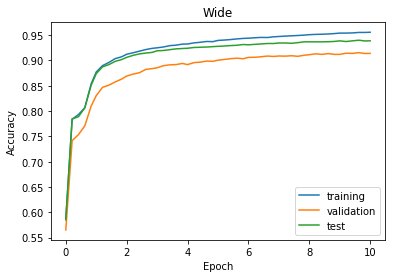

In [13]:
report(result_wide, 'wide')

### Number of Hidden Layers

In [14]:
%%time
d_in, d_old, d_out = sizes
# Solve the new dimension
d_sum = d_in + d_out
d_new = int(np.round((np.sqrt(d_sum ** 2 + 4 * d_sum * d_old) - d_sum) / 2))
print('New hidden layer dimension is', d_new)
sizes_deep = [d_in, d_new, d_new, d_out]
result_deep = trick_train(sizes_deep)

New hidden layer dimension is 60
CPU times: user 1min 11s, sys: 11.9 s, total: 1min 23s
Wall time: 47.7 s


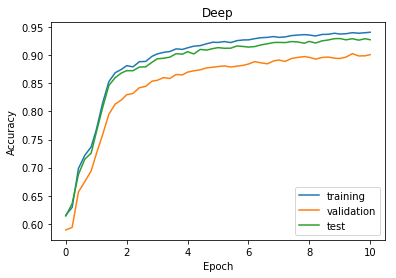

In [15]:
report(result_deep, 'deep')